In [1780]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.fft import rfft, rfftfreq, fft, fftfreq
from scipy import signal
import cmath, math

In [1781]:
plt.rcParams["figure.figsize"] = (15, 5)

In [1782]:
def generate_sine_wave(freq, sample_rate, duration):
    x = np.linspace(0, duration, sample_rate * duration, endpoint=False)
    frequencies = x * freq
    # 2pi для преобразования в радианы
    y = np.sin((2 * np.pi) * frequencies)
    return x, y

# Генерируем волну с частотой 2 Гц, которая длится 5 секунд
# x, y = generate_sine_wave(2, 1000, 1)
# plt.plot(x, y)
# plt.show()

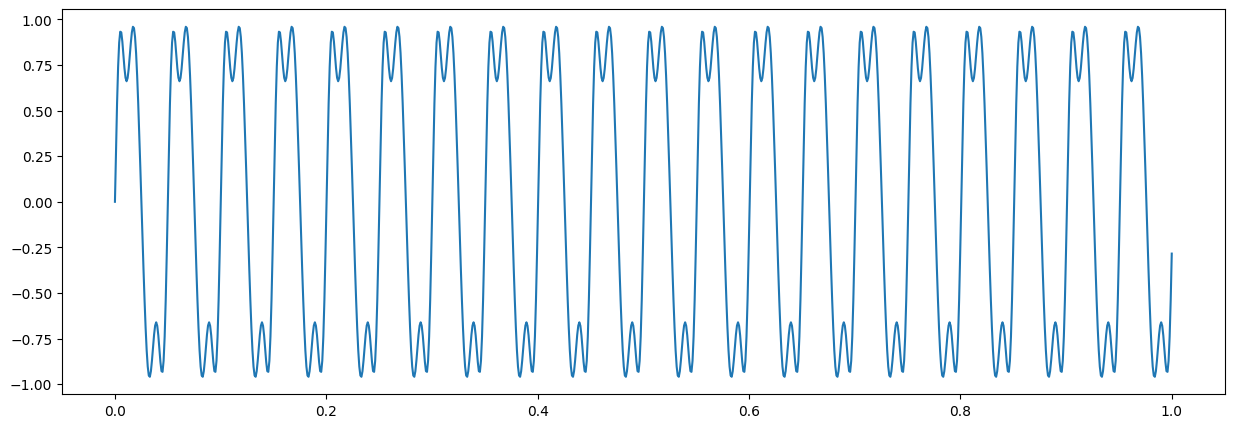

In [1783]:
SAMPLE_RATE = 1000
DURATION = 1
N = SAMPLE_RATE * DURATION

_, nice_tone = generate_sine_wave(20, SAMPLE_RATE, DURATION)
_, noise_tone1 = generate_sine_wave(80, SAMPLE_RATE, DURATION)
_, noise_tone2 = generate_sine_wave(60, SAMPLE_RATE, DURATION)

noise_tone = 0.1 * noise_tone1 + 0.3 * noise_tone2
mixed_tone = 1 * nice_tone + noise_tone

plt.plot(np.linspace(0, DURATION, N), mixed_tone)
plt.show()

In [1784]:
def transformFrequency(w):
    return np.tan(np.pi * w / SAMPLE_RATE)

In [1785]:
def AFH_H(w, cutoff, n=2):
    return 1 / np.sqrt(1 + (w / cutoff) ** (2 * n))

# cutoff задает частоту среза фильтра Баттерворта

In [1786]:
n = 4
cutoff = 22

w = transformFrequency(cutoff)

In [1787]:
def C(k, n):
    return math.factorial(n) / (math.factorial(n - k) * math.factorial(k))

In [1788]:
def getCoeffs(n, w):
    if n % 2 == 0:
        numerator = ((- w * w) ** (n / 2)) * np.array([C(k, n) for k in range(n + 1)])

        denominator = np.zeros(n + 1)

        def denCoeffs(degree=0, prod=1, k=1):
            def a(k):
                return 2 * w * math.cos(math.pi * k / n) * math.sin(math.pi / (2 * n)) - 2 * w * math.sin(
                    math.pi * k / n) * math.cos(math.pi / (2 * n)) - w * w - 1

            def b(k):
                return -2 * w * w + 2

            def c(k):
                return -2 * w * math.cos(math.pi * k / n) * math.sin(math.pi / (2 * n)) + 2 * w * math.sin(
                    math.pi * k / n) * math.cos(math.pi / (2 * n)) - w * w - 1

            if k > n / 2:
                denominator[degree] += prod
                return

            if degree + 2 <= n:
                denCoeffs(degree + 2, prod * a(k), k + 1)

            if degree + 1 <= n:
                denCoeffs(degree + 1, prod * b(k), k + 1)

            if degree <= n:
                denCoeffs(degree, prod * c(k), k + 1)

        denCoeffs()

        a0 = denominator[-1]
        return numerator / a0, denominator[:-1] / a0
    else:
        raise ValueError("n have to even number for a while")

In [1789]:
def processingOfSignal(input, n=2):
    numerator, denominator = getCoeffs(n, w)

    numberOfX = numerator.size
    numberOfY = denominator.size

    output = np.zeros_like(input)
    # output = input.copy()

    for i in range(output.size - numberOfX + 1):
        output[numberOfX - 1 + i] = (input[i:numberOfX + i] * numerator).sum() - (
                    output[(numberOfX - 1 + i) - numberOfY:numberOfX - 1 + i] * denominator).sum()

    return output

    # _x = np.array(input[:3])
    # _y = np.zeros(3)
    #
    # for i, x in enumerate(input[2:]):
    #     _x[2] = x
    #
    #     # convolution
    #     _y[2] = b0 * _x[2] + b1 * _x[1] + b2 * _x[0] - a1 * _y[1] - a2 * _y[0]
    #     output[i] = _y[2]
    #
    #     # shifting
    #     _x = np.roll(_x, -1)
    #     _y = np.roll(_y, -1)

    # return output


# output = processingOfSignal(mixed_tone, 20)

In [1790]:
yf = rfft(mixed_tone)
xf = rfftfreq(N, 1 / SAMPLE_RATE)

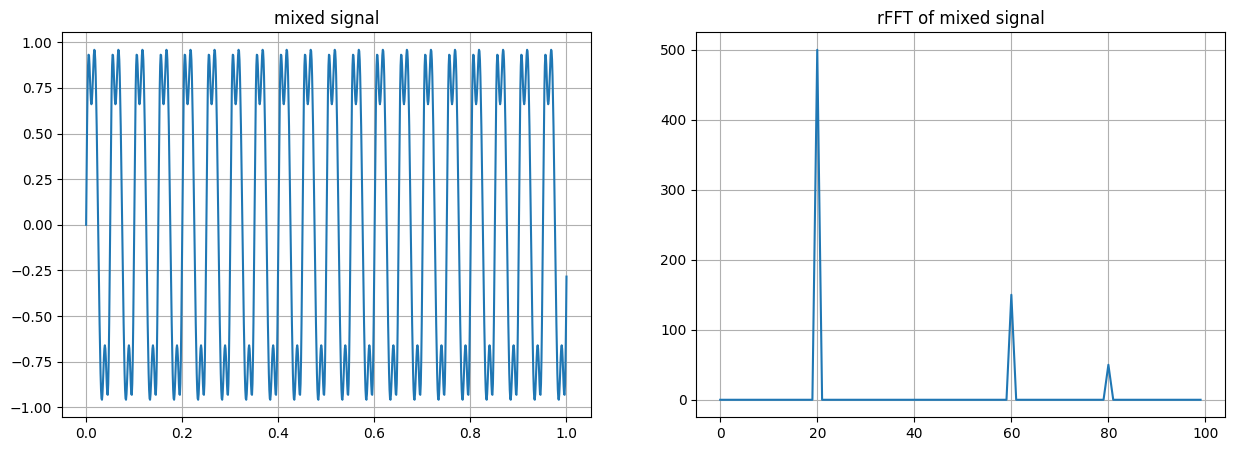

In [1791]:
plt.subplot(1, 2, 1)
plt.plot(np.linspace(0, DURATION, N), mixed_tone)
plt.grid()
plt.title("mixed signal")

bound = 100
plt.subplot(1, 2, 2)
plt.plot(xf[:bound], np.abs(yf[:bound]))
plt.grid()
plt.title("rFFT of mixed signal")

plt.show()

In [1792]:
output = processingOfSignal(mixed_tone, n)
yf = rfft(output)
xf = rfftfreq(N, 1 / SAMPLE_RATE)

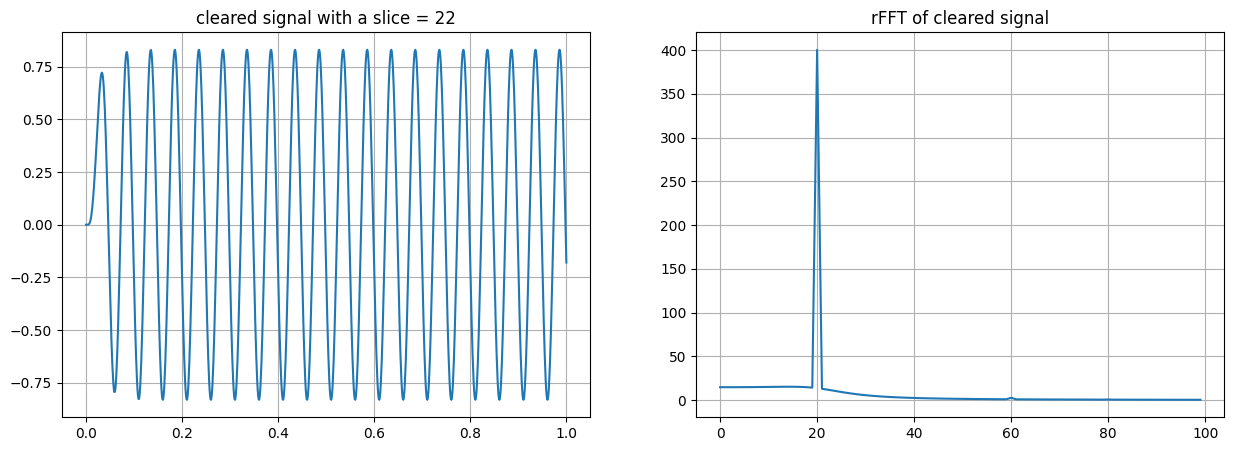

In [1793]:
plt.subplot(1, 2, 1)
plt.plot(np.linspace(0, DURATION, N), output)
plt.grid()
plt.title(f"cleared signal with a slice = {cutoff}")

bound = 100
plt.subplot(1, 2, 2)
plt.plot(xf[:bound], np.abs(yf[:bound]))
plt.grid()
plt.title("rFFT of cleared signal")

plt.show()

# АЧХ аналоговой функции Баттерворта с указанием порядка и частоты среза
# АФХ аналоговой функции Баттерворта

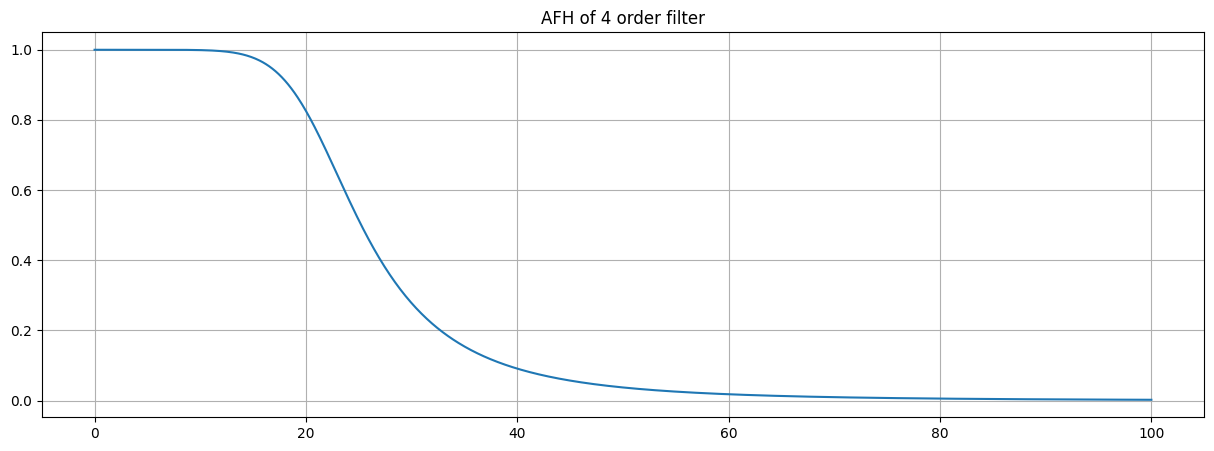

In [1794]:
f = np.linspace(0, 100, 1000)

# plt.subplot(1, 2, 1)
plt.plot(f, AFH_H(f, cutoff, n))
plt.grid()
plt.title(f"AFH of {n} order filter")

# plt.subplot(1, 2, 2)
# H_jw = 1 / (-f ** 2 + np.sqrt(2) * f * 1j + 1)
# plt.plot(f, [cmath.phase(i) for i in H_jw])
# plt.grid()
# plt.title("APH of filter")

plt.show()

# Видим что питоновская функция выдает такой же АЧХ, только не смещенный относительно частоты среза
Коэффициенты подобраны исходя из второго порядка фильтра

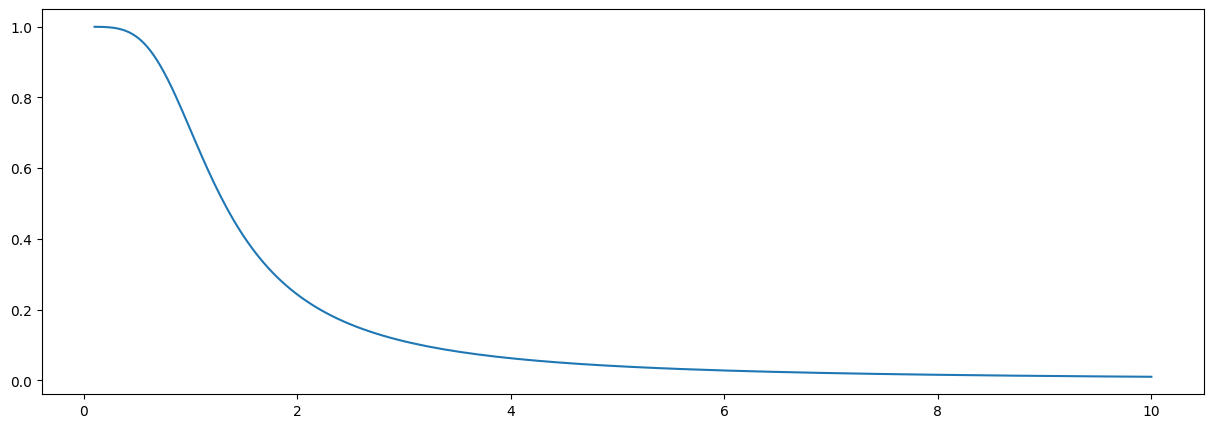

In [1795]:
system = ([1.0], [1.0, np.sqrt(2.0), 1.0])
t, y = signal.impulse2(system)

plt.plot(*np.abs(signal.freqs(*system)))